In [ ]:
# Installing Necessary libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

In [ ]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Convert `last contact date` to datetime format in both datasets
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'], errors='coerce')
test_df['last contact date'] = pd.to_datetime(test_df['last contact date'], errors='coerce')

In [ ]:
# Extracting day, month, and year from `last contact date`
for df in [train_df, test_df]:
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_year'] = df['last contact date'].dt.year

In [ ]:
# Drop original `last contact date` column as it's no longer needed
train_df.drop(columns=['last contact date'], inplace=True)
test_df.drop(columns=['last contact date'], inplace=True)


In [ ]:
# Summarizing missing values
missing_values_train = train_df.isnull().sum()
missing_values_test = test_df.isnull().sum()


In [ ]:
# Numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
# Removing the target column from categorical columns for EDA purposes
if 'target' in categorical_cols:
    categorical_cols.remove('target')

In [ ]:
# Statistical summary of numerical columns
numerical_summary = train_df[numerical_cols].describe()

In [ ]:
# Visualization of target variable distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=train_df['target'].value_counts().index, y=train_df['target'].value_counts().values, palette="viridis")
plt.title('Target Variable Distribution')
plt.ylabel('Proportion')
plt.xlabel('Target')
plt.show()


In [ ]:
# Visualize correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
# Handling missing values
for col in ['job', 'education', 'contact']:
    if col in train_df.columns:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
    if col in test_df.columns:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [ ]:
# Dropping `poutcome` if it exists
if 'poutcome' in train_df.columns:
    train_df.drop(columns=['poutcome'], inplace=True)
if 'poutcome' in test_df.columns:
    test_df.drop(columns=['poutcome'], inplace=True)

In [ ]:
# Capping outliers in `balance` and `campaign`
for col, cap in [('balance', 30000), ('campaign', 20)]:
    if col in train_df.columns:
        train_df[col] = np.clip(train_df[col], -cap, cap)
    if col in test_df.columns:
        test_df[col] = np.clip(test_df[col], -cap, cap)

In [ ]:
# Encoding categorical variables
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

In [ ]:
# Align test data with training data (to handle potential column mismatches)
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

In [ ]:
# Scaling numerical features
scaler = MinMaxScaler()
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
train_encoded[numerical_cols] = scaler.fit_transform(train_encoded[numerical_cols])
test_encoded[numerical_cols] = scaler.transform(test_encoded[numerical_cols])

In [ ]:
# Final training and test datasets
X_train = train_encoded.drop(columns=['target'])
y_train = train_encoded['target'].map({'yes': 1, 'no': 0})
X_test = test_encoded.drop(columns=['target'], errors='ignore')

In [ ]:
# Initialize models
svc = SVC(kernel='rbf', random_state=42, probability=True)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)
lgbm = LGBMClassifier(random_state=42)

In [ ]:
# Dictionary to store models and their results
models = {'SVC': svc, 'RFC': rfc, 'Logistic Regression': lr, 'LGBM': lgbm}
results = {}

In [ ]:
# Train and evaluate models using 5-fold cross-validation with macro-averaged F1-score
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    results[model_name] = {
        'Mean Macro F1': scores.mean(),
        'Macro F1 Std Dev': scores.std()
    }
    print(f"{model_name} - Mean Macro F1: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")

In [ ]:
# Train and evaluate models using 5-fold cross-validation
for model_name, model in models.items():
    scores_1 = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = {
        'Mean Accuracy': scores_1.mean(),
        'Accuracy Std Dev': scores_1.std()
    }
    print(f"{model_name} - Mean Accuracy: {scores_1.mean():.4f}, Std Dev: {scores_1.std():.4f}")

In [ ]:
# Fit each model on the training data
for model_name, model in models.items():
    model.fit(X_train, y_train)

In [ ]:
# Evaluate macro F1-score if true test labels are available
if 'target' in test_df.columns:
    y_test = test_encoded['target'].map({'yes': 1, 'no': 0})
    macro_f1_test = f1_score(y_test, test_predictions_best, average='macro')
    print(f"Macro F1-score on Test Set: {macro_f1_test:.4f}")

In [ ]:
# Choose the best model based on cross-validation accuracy
best_model_name = max(results, key=lambda x: results[x]['Mean Accuracy'])
best_model = models[best_model_name]

C:\Users\Asus\AppData\Local\Temp\ipykernel_22600\2689434614.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_df['target'].value_counts().index, y=train_df['target'].value_counts().values, palette="viridis")


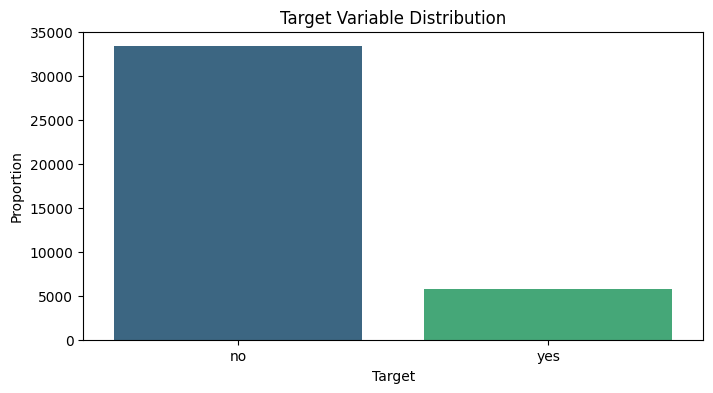

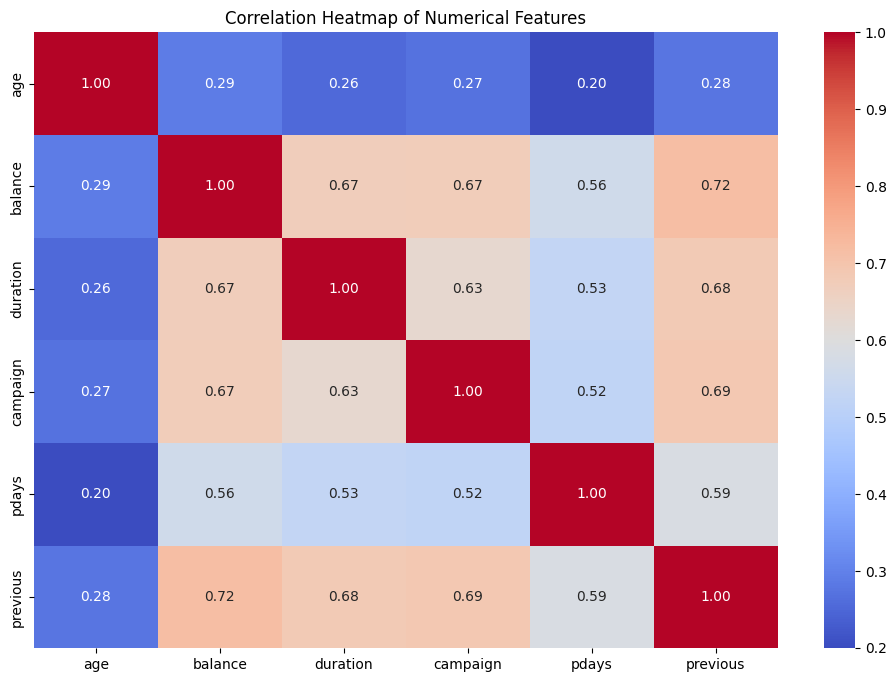

SVC - Mean Macro F1: 0.4599, Std Dev: 0.0000
RFC - Mean Macro F1: 0.7034, Std Dev: 0.0061


C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Logistic Regression - Mean Macro F1: 0.6189, Std Dev: 0.0051
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1168
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
[LightGBM] [Info] Number of positive: 4662, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train

C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Logistic Regression - Mean Accuracy: 0.8588, Std Dev: 0.0020
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1168
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
[LightGBM] [Info] Number of positive: 4662, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train

C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2]:


















































# Generate predictions using the best model
test_predictions_best = best_model.predict(X_test)


# Create the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df.index,  # Ensure indices align with the test data
    'target': best_model
})


# Convert numeric predictions back to "yes" or "no"
submission_df['target'] = submission_df['target'].map({1: 'yes', 0: 'no'})

# Save the predictions in the submission format
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Best Model: {best_model_name}")
